# Simple LSTM for track finding on 1D detector layers

In [1]:
# System imports
from __future__ import print_function

# External imports
import numpy as np
from keras import models
from keras import layers

# Local imports
from toy2d import (generate_straight_track, generate_straight_tracks,
                   generate_uniform_noise, generate_track_bkg)
from drawing import draw_2d_event, draw_2d_input_and_pred, draw_train_history
from metrics import calc_hit_accuracy

from matplotlib import pyplot as plt
%matplotlib notebook

/home/nicole/anaconda3/envs/trackml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data generation

In [2]:
# Detector parameters
det_width = 50
det_depth = 50
det_shape = (det_depth, det_width)
seed_size = 5

In [3]:
def batch_generator(num_events, det_shape, num_bkg_tracks, noise_prob,
                    seed_size, binary=True):
    while True:
        # Generate signal tracks in the masked region
        sig_tracks = generate_straight_tracks(num_events, det_shape)
        # Generate track background
        bkg_tracks = generate_track_bkg(num_events, det_shape,
                                        tracks_per_event=num_bkg_tracks,
                                        skip_layers=seed_size)
        # Generate noise background
        noise = generate_uniform_noise(num_events, det_shape,
                                       prob=noise_prob)
        # Combine into full events
        events = sig_tracks + bkg_tracks + noise
        if binary:
            events[events > 1] = 1

        # Mask the data
        yield events, sig_tracks

## Simple LSTM track finding model

In [4]:
def build_model(num_hidden, det_shape,
                loss='categorical_crossentropy',
                optimizer='Nadam', metrics=['accuracy']):
    inputs = layers.Input(shape=det_shape)
    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True)(inputs)
    outputs = layers.TimeDistributed(layers.Dense(det_shape[1], activation='softmax'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

## Single tracks with uniform noise

Here we look at events with 20% uniform binary noise hits and one signal track. The goal of the LSTM is to select the pixels belonging to the target track.

In [8]:
# Data config
num_bkg_tracks = 0
noise_prob = 0.2

# Model config
num_hidden = 50

# Training config
batch_size = 16
num_epoch = 10
epoch_size = 1024


In [9]:
# Prepare the batch generator
batcher1 = batch_generator(batch_size, det_shape,
                           num_bkg_tracks=num_bkg_tracks,
                           noise_prob=noise_prob, seed_size=seed_size)

# Prepare the model
model1 = build_model(num_hidden, det_shape)
model1.summary()

# Train the model
history1 = model1.fit_generator(batcher1, samples_per_epoch=epoch_size,
                                nb_epoch=num_epoch)

/home/nicole/anaconda3/envs/trackml/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, units=50)`
  """
/home/nicole/anaconda3/envs/trackml/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ti...)`
  import sys
/home/nicole/anaconda3/envs/trackml/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/home/nicole/anaconda3/envs/trackml/lib/python3.6/site-packages/ipykerne

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 50)            20200     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 50, 50)            2550      
Total params: 22,750
Trainable params: 22,750
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1024/1024 [==============================] - 25s 25ms/step - loss: 1.8758 - acc: 0.5133
Epoch 2/10
1024/1024 [==============================] - 45s 44ms/step - loss: 0.8366 - acc: 0.7456
Epoch 3/10
1024/1024 [==============================] - 37s 36ms/step - loss: 0.5569 - acc: 0.8162
Epoch 4/10
1024/1024 [==============================] - 33s 32ms/step - loss: 0.4591 - acc: 0.8428
Epoch 

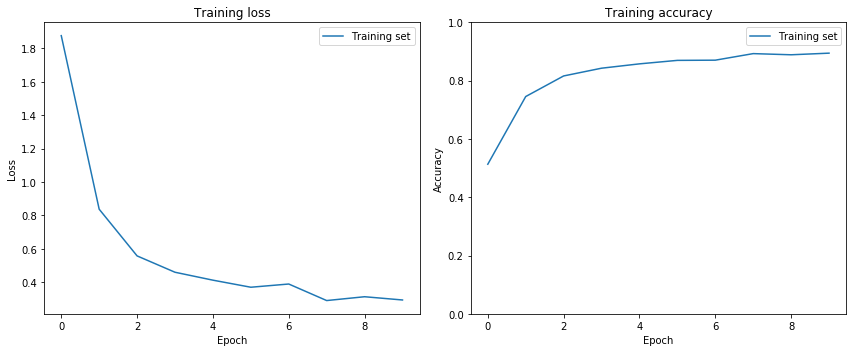

In [10]:
draw_train_history(history1, draw_val=False);

In [13]:
# Generate a test set
num_test = 10240
test1_input, test1_target = next(batch_generator(
    num_test, det_shape, num_bkg_tracks=num_bkg_tracks,
    noise_prob=noise_prob, seed_size=seed_size))

# Get test set predictions
test1_pred = model1.predict(test1_input)
test1_loss, test1_acc = model1.evaluate(test1_input, test1_target)

10240/10240 [==============================] - 3s 250us/step


In [14]:
# Hit prediction accuracy
pixel_accuracy = calc_hit_accuracy(test1_pred, test1_target,
                                   num_seed_layers=seed_size)
# Hit classification accuracy
test1_scores = test1_pred * test1_input
hit_accuracy = calc_hit_accuracy(test1_scores, test1_target)

# Print a test set summary
print('Test set loss', test1_loss)
print('Accuracy of predicted pixel:', pixel_accuracy)
print('Accuracy of classified hit: ', hit_accuracy)

Test set loss 0.3156241285149008
Accuracy of predicted pixel: 0.8712217881944444
Accuracy of classified hit:  0.8900078125


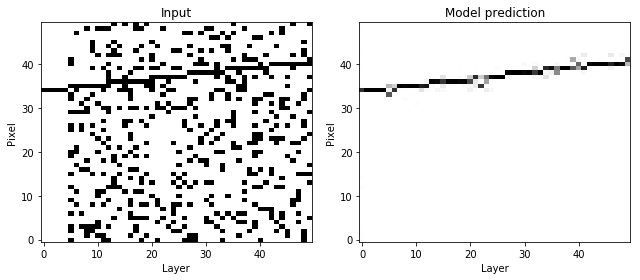

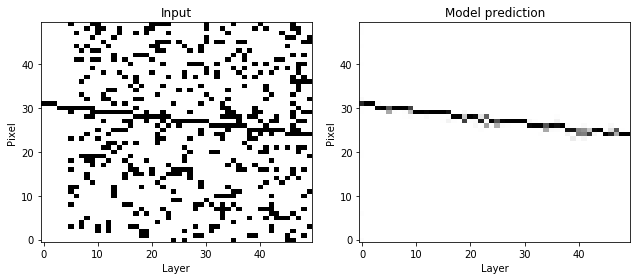

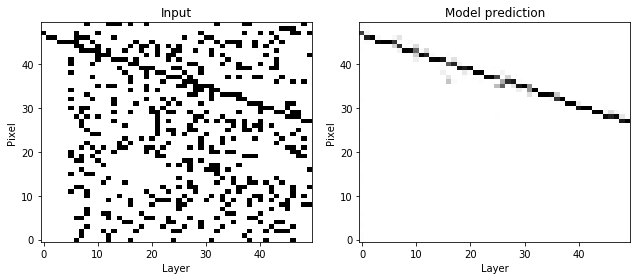

In [15]:
# Visualize predictions
for i in [0, 1, 2]:
    draw_2d_input_and_pred(test1_input[i], test1_pred[i], cmap='gray_r');

## Multi-track background

Now let's try the scenario where each event has background tracks in addition to the signal track, but no noise.

In [17]:
# Data config
num_bkg_tracks = 5
noise_prob = 0

# Model config
num_hidden = 100

# Training config
batch_size = 16
num_epoch = 10
epoch_size = 1024

In [18]:
# Prepare the batch generator
batcher2 = batch_generator(batch_size, det_shape,
                           num_bkg_tracks=num_bkg_tracks,
                           noise_prob=noise_prob, seed_size=seed_size)

# Prepare the model
model2 = build_model(num_hidden, det_shape)
model2.summary()

# Train the model
history2 = model2.fit_generator(batcher2, samples_per_epoch=epoch_size,
                                nb_epoch=num_epoch)

/home/nicole/anaconda3/envs/trackml/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, units=100)`
  """
/home/nicole/anaconda3/envs/trackml/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ti...)`
  import sys
/home/nicole/anaconda3/envs/trackml/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/home/nicole/anaconda3/envs/trackml/lib/python3.6/site-packages/ipykern

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 100)           60400     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 50, 50)            5050      
Total params: 65,450
Trainable params: 65,450
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1024/1024 [==============================] - 42s 41ms/step - loss: 1.9080 - acc: 0.3686
Epoch 2/10
1024/1024 [==============================] - 57s 55ms/step - loss: 1.2050 - acc: 0.5100
Epoch 3/10
1024/1024 [==============================] - 35s 34ms/step - loss: 1.0150 - acc: 0.6059
Epoch 4/10
1024/1024 [==============================] - 57s 56ms/step - loss: 0.8946 - acc: 0.6701
Epoch 

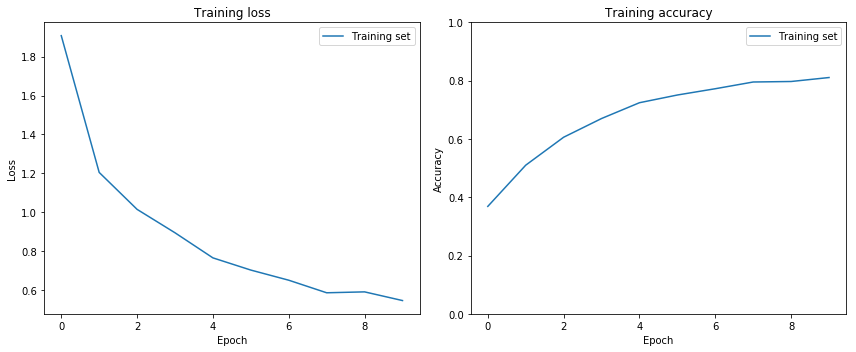

In [19]:
draw_train_history(history2, draw_val=False);

In [21]:
# Generate a test set
num_test = 10240
test2_input, test2_target = next(batch_generator(
    num_test, det_shape, num_bkg_tracks=num_bkg_tracks,
    noise_prob=noise_prob, seed_size=seed_size))

# Get test set predictions
test2_pred = model2.predict(test2_input)
test2_loss, test2_acc = model2.evaluate(test2_input, test2_target)

10240/10240 [==============================] - 4s 388us/step


In [22]:
# Hit prediction accuracy
pixel_accuracy = calc_hit_accuracy(test2_pred, test2_target,
                                   num_seed_layers=seed_size)
# Hit classification accuracy
test2_scores = test2_pred * test2_input
hit_accuracy = calc_hit_accuracy(test2_scores, test2_target)

# Print a test set summary
print('Test set loss', test2_loss)
print('Accuracy of predicted pixel:', pixel_accuracy)
print('Accuracy of classified hit: ', hit_accuracy)

Test set loss 0.4986131964251399
Accuracy of predicted pixel: 0.81015625
Accuracy of classified hit:  0.829939453125


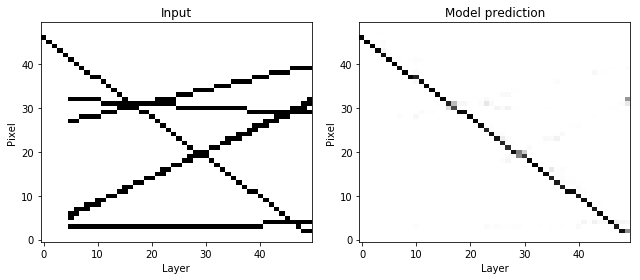

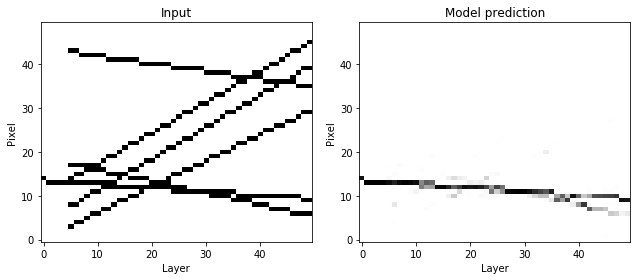

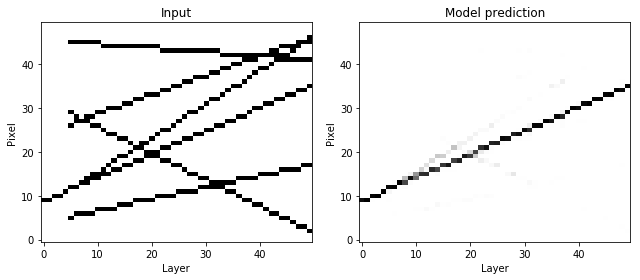

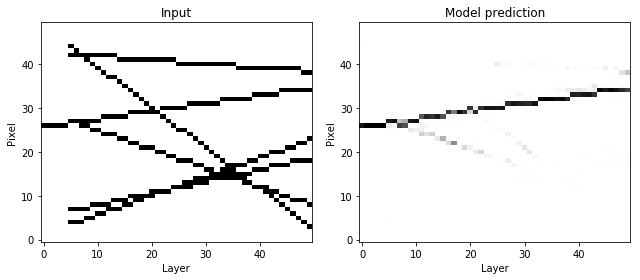

In [28]:
# Visualize predictions
for i in [0, 1, 2, 3]:
    draw_2d_input_and_pred(test2_input[i], test2_pred[i], cmap='gray_r');